In [4]:
%matplotlib inline
import psycopg2
ASOS = psycopg2.connect(database='asos', host='iemdb', user='nobody')
acursor = ASOS.cursor()

hrs = []
tmpf = []
days = []
acursor.execute("""SELECT date(valid ) as d,
  extract(hour  from valid + '10 minutes'::interval) as hr
  , min(round(tmpf::numeric,0)) from t2016
  where station = 'DSM' and valid > '2016-03-07 23:50' 
  and valid < '2016-03-08 23:00' GROUP by d, hr ORDER by d, hr ASC""")
for row in acursor:
    tmpf.append( float(row[2]) )
    hrs.append( row[1] )
    days.append( row[0]) 

print hrs

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]


In [2]:
import mx.DateTime
thursdays =[]
for yr in range(1880,2015):
  nov1 = mx.DateTime.DateTime(yr, 2, 14)
  turkey = nov1
  #turkey = nov1 + mx.DateTime.RelativeDateTime(weekday=(mx.DateTime.Thursday,4))
  thursdays.append(turkey.strftime("%Y-%m-%d"))

In [5]:
COOP = psycopg2.connect(database='coop', host='iemdb', user='nobody')
ccursor = COOP.cursor()
dates = []
highs = []
for h, t, d in zip(hrs, tmpf, days):
    
    acursor.execute("""SELECT valid, tmpf from alldata WHERE 
extract(hour from valid + '10 minutes') = %s and station = 'DSM' 
and round(tmpf::numeric,0) >= %s
and valid < '%s' and extract(doy from valid) <= extract(doy from '%s'::date)
ORDER by valid DESC LIMIT 1""" % (h, t, d, d))
    row = acursor.fetchone()
    if row is None:
        dates.append( d )
        highs.append( -99 )
    else:
        dates.append( row[0] )
    
        ccursor.execute("""SELECT high from alldata_ia where station = 'IA2203'
    and day = '%s'""" % (row[0].strftime("%Y-%m-%d"),))
        row2 = ccursor.fetchone()
        highs.append( row2[0] )
        
    print h, t, d, dates[-1]


0.0 64.0 2016-03-07 2000-03-07 23:54:00-06:00
1.0 64.0 2016-03-08 2016-03-08
2.0 65.0 2016-03-08 2016-03-08
3.0 64.0 2016-03-08 2016-03-08
4.0 63.0 2016-03-08 2000-03-08 03:54:00-06:00
5.0 62.0 2016-03-08 2000-03-08 04:54:00-06:00
6.0 61.0 2016-03-08 2012-03-07 05:54:00-06:00
7.0 61.0 2016-03-08 2000-03-08 06:54:00-06:00
8.0 62.0 2016-03-08 2012-03-07 07:54:00-06:00
9.0 66.0 2016-03-08 2016-03-08
10.0 68.0 2016-03-08 2000-03-07 09:54:00-06:00
11.0 69.0 2016-03-08 2000-03-08 10:54:00-06:00
12.0 71.0 2016-03-08 2016-03-07 11:54:00-06:00
13.0 70.0 2016-03-08 2016-03-07 12:54:00-06:00
14.0 72.0 2016-03-08 2012-03-06 13:54:00-06:00
15.0 71.0 2016-03-08 2016-03-07 14:54:00-06:00
16.0 72.0 2016-03-08 2012-03-06 15:54:00-06:00
17.0 70.0 2016-03-08 2016-03-07 16:54:00-06:00
18.0 68.0 2016-03-08 2016-03-07 17:54:00-06:00
19.0 66.0 2016-03-08 2016-03-07 18:54:00-06:00
20.0 63.0 2016-03-08 2016-03-07 19:54:00-06:00
21.0 58.0 2016-03-08 2016-03-07 20:54:00-06:00
22.0 53.0 2016-03-08 2016-03-07 21:5

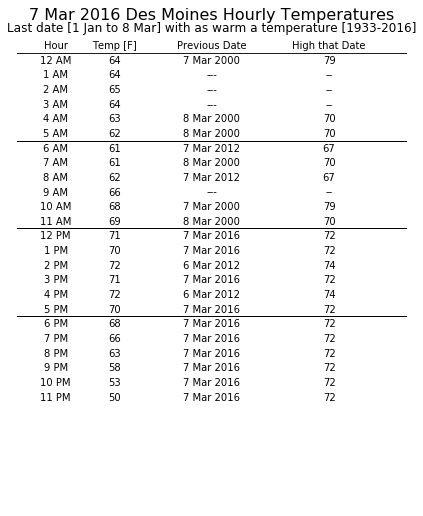

In [10]:
import datetime
import matplotlib.pyplot as plt


(fig, ax) = plt.subplots(1,1, figsize=(7,9))

ax.text(0.5, 0.97, '7 Mar 2016 Des Moines Hourly Temperatures', ha='center', size=16)
ax.text(0.5, 0.94, 'Last date [1 Jan to 8 Mar] with as warm a temperature [1933-2016]', ha='center', size=12)

ax.text(0.1, 0.90, 'Hour', ha='center')
ax.text(0.25, 0.90, 'Temp [F]', ha='center')
ax.text(0.5, 0.90, 'Previous Date', ha='center')
ax.text(0.8, 0.90, 'High that Date', ha='center')

ax.plot([0.,1.], [0.89,0.89])

y = 0.865
for h, t, d, hi in zip(hrs, tmpf, dates, highs):
    ts = datetime.datetime(2000,1,1, int(h))
    color = 'k'
    if d.year < 2000:
        color = 'r'
    ax.text(0.1, y, "%s" % (ts.strftime("%-I %p"),), ha='center', color=color)
    ax.text(0.25, y, "%.0f" % (t,), ha='center', color=color)
    if d.strftime("%Y%m%d") < datetime.datetime(2016, 3, 8).strftime("%Y%m%d"):
        ax.text(0.5, y, "%s" % (d.strftime("%-d %b %Y"),), ha='center', color=color)
        ax.text(0.8, y, "%s" % (hi,), ha='center', color=color)
    else:
        ax.text(0.5, y, "---", ha='center', color=color)
        ax.text(0.8, y, "--", ha='center', color=color)
    if h in (5,11,17):
        ax.plot([0,1], [y-0.01,y-0.01], color='k')
    y -= 0.035

ax.set_ylim(-0.2,1)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_xlim(0,1)
ax.axis('off')
    
fig.savefig('160309.png')
